In [181]:
# Imports
import pathlib

import numpy as np
import torch
from skimage.io import imread
from skimage.transform import resize

from inference import predict
from transformations import normalize_01, re_normalize
from unet import UNet
import cv2
# root directory
# root = pathlib.Path('/mnt/c/Users/crsoc/Documents/roahm/camera_preprocessing/UNet/dataset_large/val')
# root = pathlib.Path('/mnt/c/Users/crsoc/Documents/roahm/camera_preprocessing/cleaned_images/imgs_ftg_1')
# root = pathlib.Path(r'C:\Users\Lenovo\Downloads\Summer 2023\programming\Seg-camera training\UNet\dataset_large\val')
# root = pathlib.Path(r'E:\dataset_large\carpet\val')
root = pathlib.Path(r'C:\Users\Lenovo\Downloads\testing_target')

def get_filenames_of_path(path: pathlib.Path, ext: str = "*"):
    """Returns a list of files in a directory/path. Uses pathlib."""
    filenames = [file for file in path.glob(ext) if file.is_file()]
    return filenames


# input and target files
images_names = get_filenames_of_path(root / "images")
# images_names = get_filenames_of_path(root)
targets_names = get_filenames_of_path(root / "targets")

# read images and store them in memory
images = [imread(str(img_name)) for img_name in images_names]
targets = [imread(tar_name) for tar_name in targets_names]

# Resize images and targets
images_res = [resize(img, (64,64, 3)) for img in images]
resize_kwargs = {"order": 0, "anti_aliasing": False, "preserve_range": True}
targets_res = [resize(tar, (64, 64), **resize_kwargs) for tar in targets]


In [182]:
# device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# model
model = UNet(
    in_channels=3,
    out_channels=3,
    n_blocks=4,
    start_filters=32,
    activation="relu",
    normalization="batch",
    conv_mode="same",
    dim=2,
).to(device)
model_name = "checkpoints/experiment_lr_on_plateau_dataset_large_color_aug_1692224712.7671678/epoch_78.pth"
# model_name = "checkpoints/experiment_4_16_1687807002.8031003/epoch_50.pth"
model_weights = torch.load(pathlib.Path.cwd() / model_name, map_location=device)

model.load_state_dict(model_weights)


<All keys matched successfully>

In [183]:
# preprocess function
def preprocess(img: np.ndarray):
    img = np.moveaxis(img, -1, 0)  # from [H, W, C] to [C, H, W]
    img = normalize_01(img)  # linear scaling to range [0-1]
    img = np.expand_dims(img, axis=0)  # add batch dimension [B, C, H, W]
    img = img.astype(np.float32)  # typecasting to float32
    return img


# postprocess function
def postprocess(img: torch.tensor):
    img = torch.argmax(img, dim=1)  # perform argmax to generate 1 channel
    img = img.cpu().numpy()  # send to cpu and transform to numpy.ndarray
    img = np.squeeze(img) # remove batch dim and channel dim -> [H, W]
    img = re_normalize(img)  # scale it to the range [0-255]
    return img


In [184]:
# predict the segmentation maps
output = [predict(img, model, preprocess, postprocess, device) for img in images_res]


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\skimage\util\dtype.py:550: UserWarning: Downcasting int64 to uint8 without scaling because max value 2 fits in uint8
  return _convert(image, np.uint8, force_copy)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\skimage\util\dtype.py:550: UserWarning: Downcasting int64 to uint8 without scaling because max value 1 fits in uint8
  return _convert(image, np.uint8, force_copy)


In [185]:
from visual import enable_gui_qt

enable_gui_qt()
import napari

viewer = napari.Viewer()

idx = 0
img_nap = viewer.add_image(images_res[idx], name="Input")
tar_nap = viewer.add_labels(targets_res[idx].astype(np.uint8), name="Target")
out_nap = viewer.add_labels(output[idx], name="Prediction")


ERROR:root:
    Could not load requested Qt binding. Please ensure that
    PyQt4 >= 4.7, PyQt5, PyQt6, PySide >= 1.0.3, PySide2, or
    PySide6 is available, and only one is imported per session.

    Currently-imported Qt library:                              None
    PyQt5 available (requires QtCore, QtGui, QtSvg, QtWidgets): False
    PyQt6 available (requires QtCore, QtGui, QtSvg, QtWidgets): False
    PySide2 installed:                                          False
    PySide6 installed:                                          False
    Tried to load:                                              ['pyqtdefault', 'pyqt6', 'pyside6', 'pyqt5', 'pyside2']
    


tensor([0.9788, 0.9817, 0.9866, 0.9949, 0.9678, 0.9861, 0.9692, 0.9709, 0.9866,
        0.9875, 0.9866, 0.9890, 0.9878, 0.9907, 0.9905, 0.9954, 0.9907, 0.8945,
        0.9797, 0.9836, 0.9810, 0.9814, 0.9844, 0.9890, 0.9785, 0.9480, 0.9790,
        0.9915, 0.9783, 0.9912, 0.9834, 0.9868, 0.9890, 0.9922, 0.9734, 0.9902,
        0.9902, 0.9897, 0.9839, 0.9778, 0.9900, 0.9878, 0.9851, 0.9854, 0.9856,
        0.9934, 0.9900, 0.9866, 0.9829, 0.9871, 0.9885, 0.9927, 0.9932, 0.9836,
        0.8677, 0.9766, 0.9839, 0.9905, 0.9807, 0.9819, 0.9817, 0.9810, 0.9919,
        0.9846, 0.9697, 0.9800, 0.9885, 0.9885, 0.9849, 0.9856, 0.9839])
tensor(0.8677)
tensor(55)
tensor(0.9816)
1


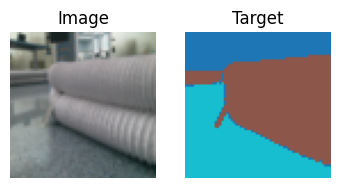

2


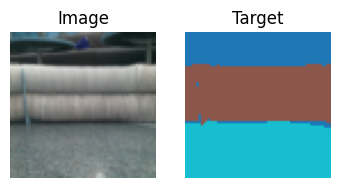

3


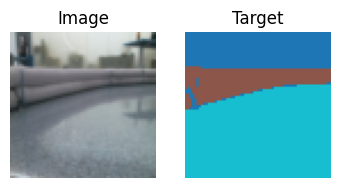

4


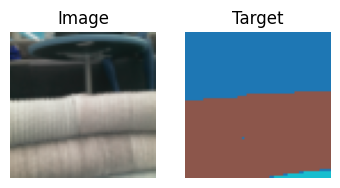

5


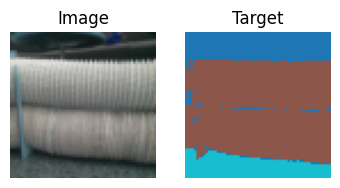

6


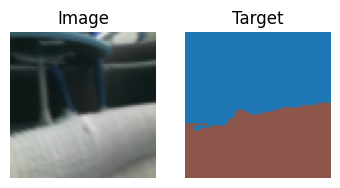

7


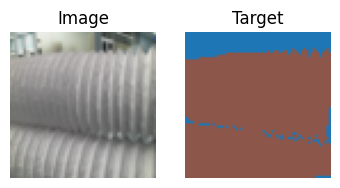

8


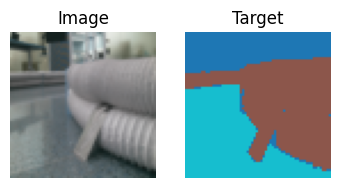

9


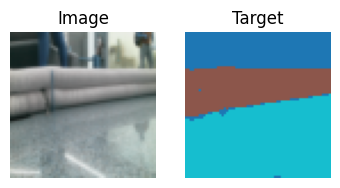

10


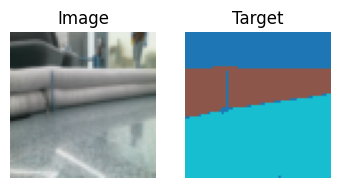

11


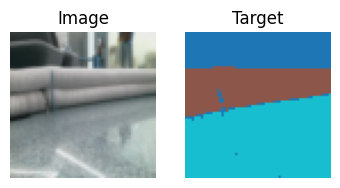

12


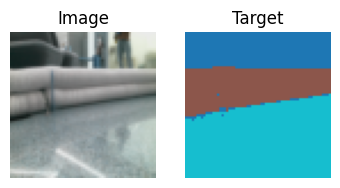

13


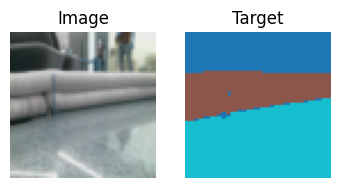

14


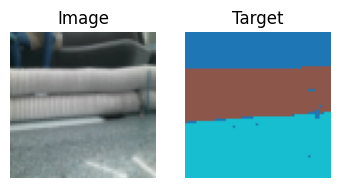

15


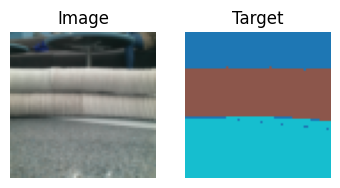

16


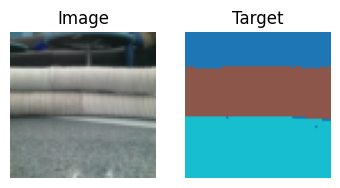

17


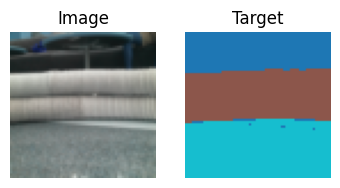

18


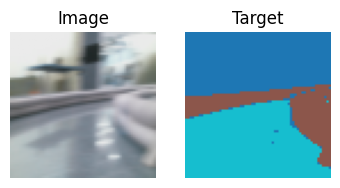

19


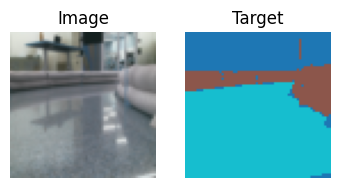

20


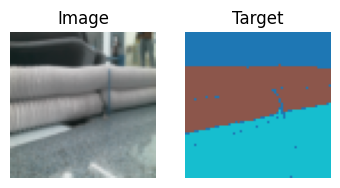

21


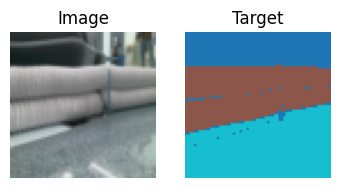

22


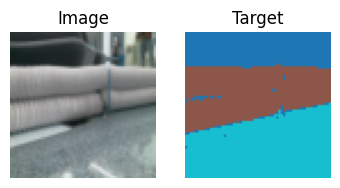

23


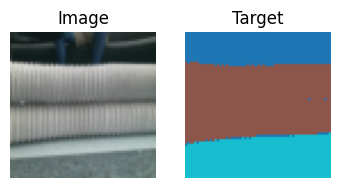

24


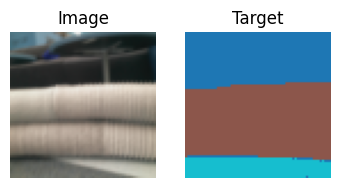

25


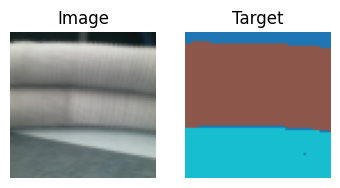

26


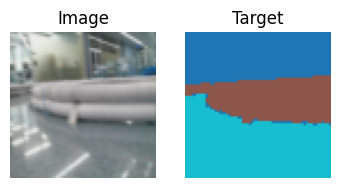

27


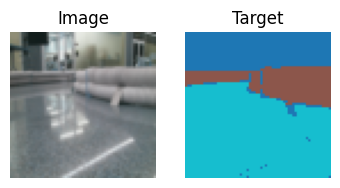

28


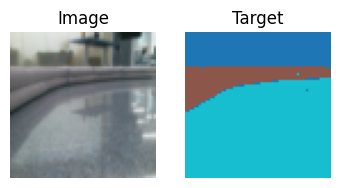

29


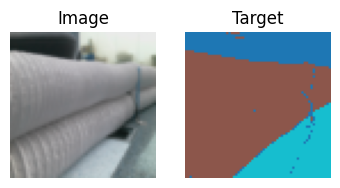

30


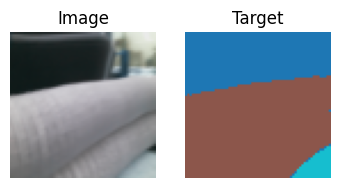

31


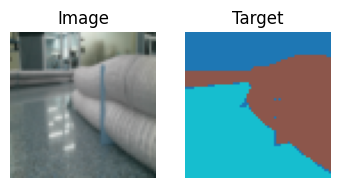

32


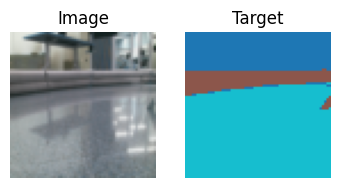

33


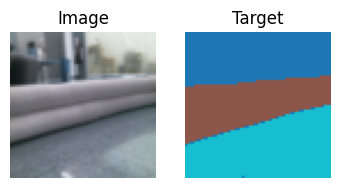

34


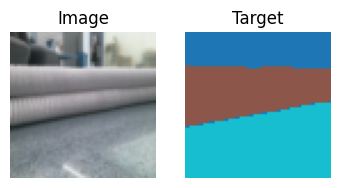

35


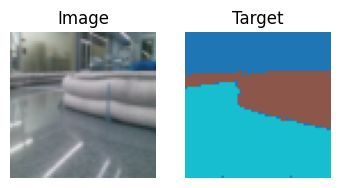

36


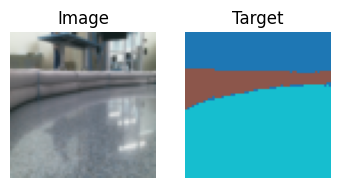

37


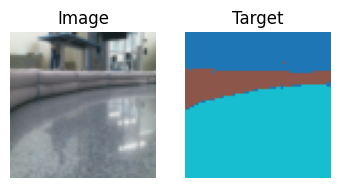

38


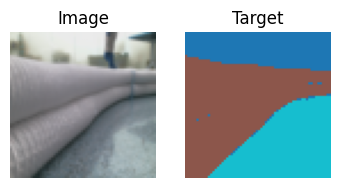

39


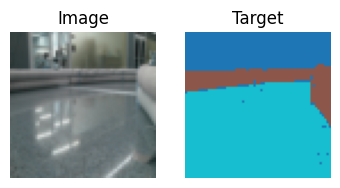

40


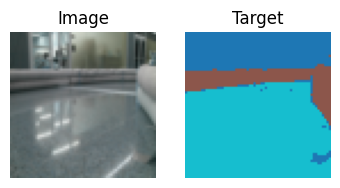

41


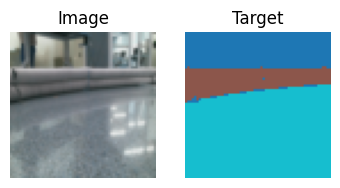

42


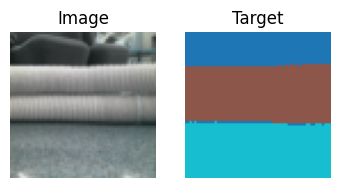

43


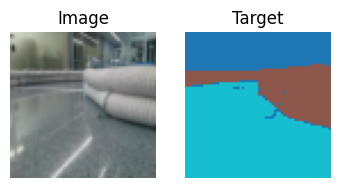

44


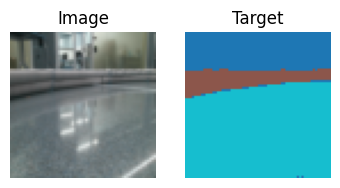

45


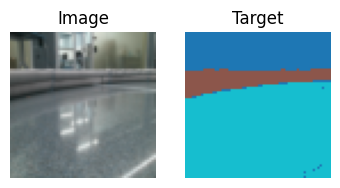

46


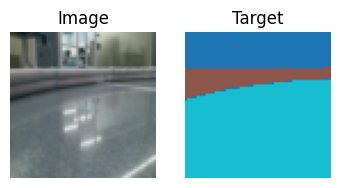

47


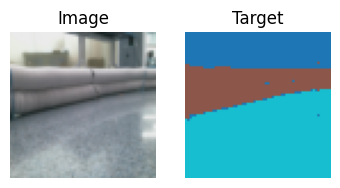

48


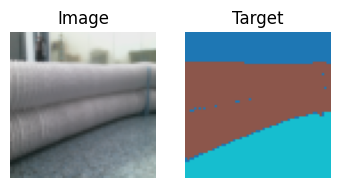

49


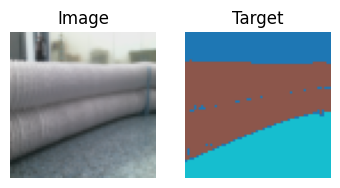

50


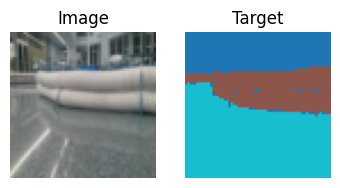

51


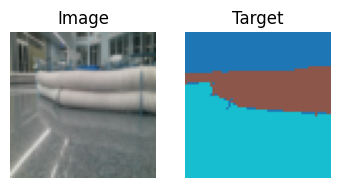

52


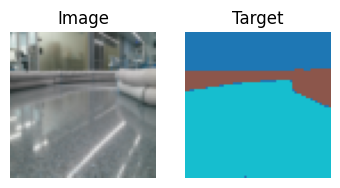

53


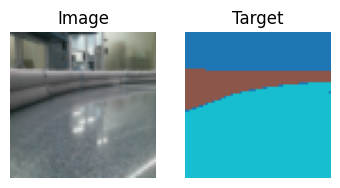

54


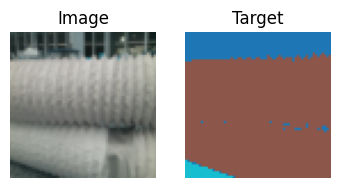

55


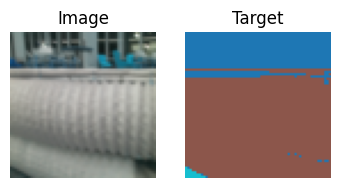

56


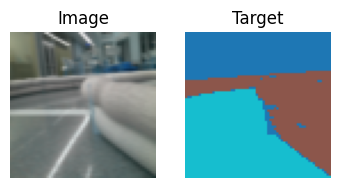

57


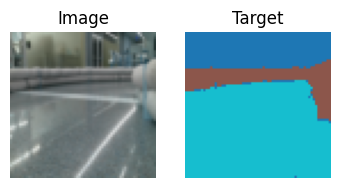

58


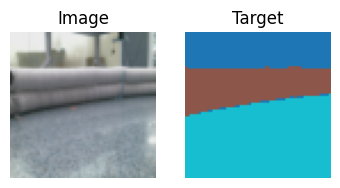

59


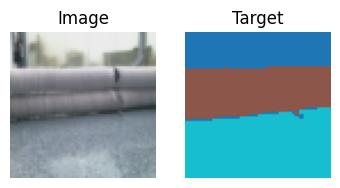

60


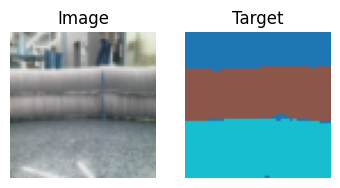

61


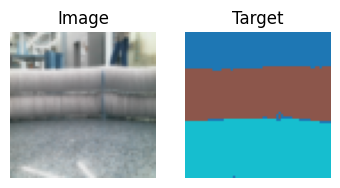

62


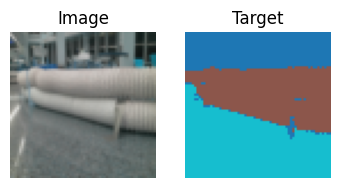

63


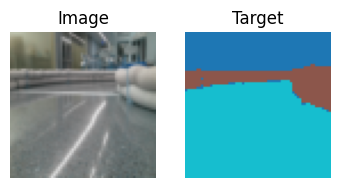

64


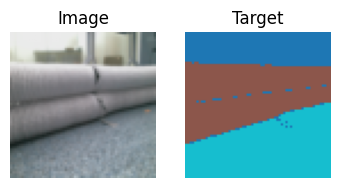

65


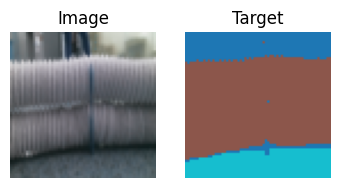

66


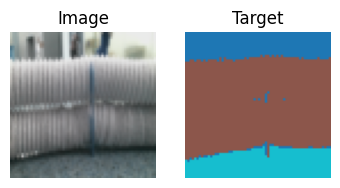

67


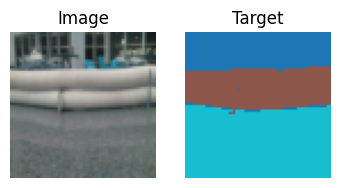

68


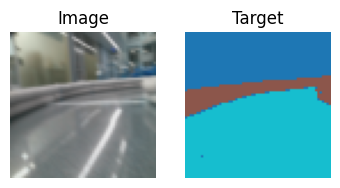

69


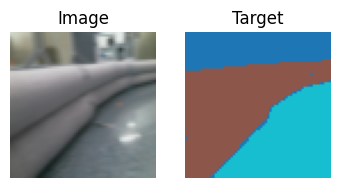

70


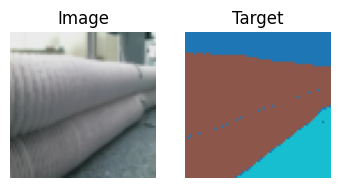

71


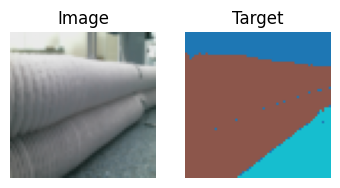

In [186]:
import matplotlib.pyplot as plt
# print(targets_res[0].shape)

def dice_loss(y_true, y_pred, smooth=1e-5):
    intersection = torch.sum(y_true * y_pred, dim=(1,2,3))
    sum_of_squares_pred = torch.sum(torch.square(y_pred), dim=(1,2,3))
    sum_of_squares_true = torch.sum(torch.square(y_true), dim=(1,2,3))
    dice = 1 - (2 * intersection + smooth) / (sum_of_squares_pred + sum_of_squares_true + smooth)
    return dice

y_true = torch.zeros(len(images),3,64,64)
y_pred = torch.zeros(len(images),3,64,64)

# print(y_true.shape)
for i in range(len(images)):
    temp = torch.zeros(64,64)
    temp[targets_res[i]==0] = 1
    y_true[i,0,:,:] = temp 

    temp = torch.zeros(64,64)
    temp[targets_res[i]==1] = 1
    y_true[i,1,:,:] = temp

    temp = torch.zeros(64,64)
    temp[targets_res[i]==2] = 1
    y_true[i,2,:,:] = temp
    
    # print(output[i])
    temp1 = torch.zeros(64,64)
    temp1[output[i]==0] = 1
    y_pred[i,0,:,:] = temp1 

    temp1 = torch.zeros(64,64)
    temp1[output[i]==1] = 1
    y_pred[i,1,:,:] = temp1

    temp1 = torch.zeros(64,64)
    temp1[output[i]==2] = 1
    y_pred[i,2,:,:] = temp1

dice = dice_loss(y_true, y_pred)

print(1-dice)
print(torch.min(1-dice))
print(torch.argmin(1-dice)+1)
print(torch.mean(1-dice))

for i in range(len(images)):  
    if i>=0:
        print(i+1)
        plt.subplot(131)
        plt.imshow(images_res[i])
        plt.title("Image")
        plt.axis('off')
        
        plt.subplot(132)
        temp1 = np.zeros((64, 64, 3), dtype=np.uint8)
        temp1[targets_res[i]==0] = [30, 119, 180]
        temp1[targets_res[i]==1] = [140, 86, 75]
        temp1[targets_res[i]==2] = [22, 190, 207]
        # plt.imshow(output[i]*127, cmap='gray')
        plt.imshow(temp1)
        plt.title("Target")
        plt.axis('off')
        
        plt.subplot(133)
        temp = np.zeros((64, 64, 3), dtype=np.uint8)
        temp[output[i]==0] = [30, 119, 180]
        temp[output[i]==1] = [140, 86, 75]
        temp[output[i]==2] = [22, 190, 207]
        plt.imshow(temp)
        plt.title("Prediction")
        plt.axis('off')    
        
        plt.show()